# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.4 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=3ef8658edea272f74cb5c2ca31453793a5a02479beea22772f6d43e0f68d267e
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=0a095496b30338400c9c48ff35d2e5b321e9339392bb2a5b02e57170cabbd04d
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels
  Cloning https://github.com/albumentations-team/albumenta

# About Dataset

### Dataset

Here the dataset which we are going to use in this guided project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

### Full Dataset

After compeletion of this project you can try the same pipeline on full dataset

https://www.cs.toronto.edu/~vmnih/data/

```
@phdthesis{MnihThesis,
author = {Volodymyr Mnih},
title = {Machine Learning for Aerial Image Labeling},
school = {University of Toronto},
year = {2013}
}
```

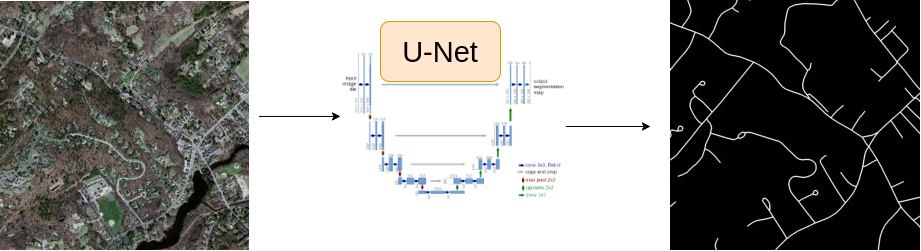

# Download Subset Dataset

In [2]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

Cloning into 'Road_seg_dataset'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411
Receiving objects: 100% (411/411), 851.74 MiB | 32.63 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (401/401), done.


# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [5]:
CSV_FILE ='/content/Road_seg_dataset/train.csv'
DATA_DIR = '/content/Road_seg_dataset/'

#DEVICE = 'cuda'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 15
LR = 0.003
BATCH_SIZE = 8
IMG_SIZE = 512

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [7]:
idx = 2

row = df.iloc[idx]

image_path = DATA_DIR + row.images
mask_path = DATA_DIR + row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255

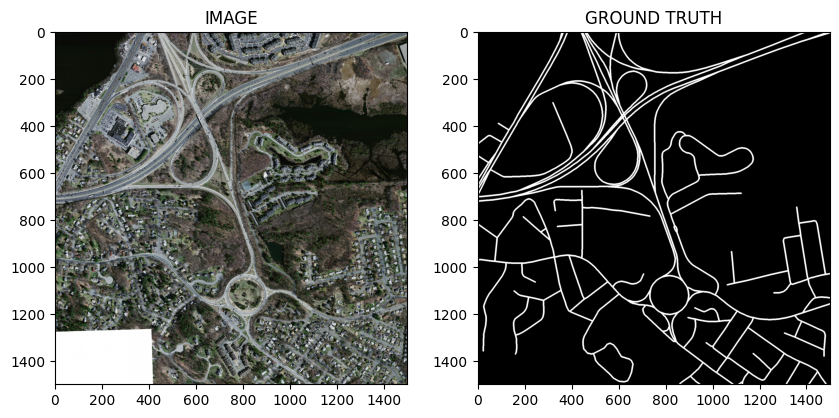

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [9]:
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state = 42)

In [10]:
len(train_df)

159

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [11]:
import albumentations as A

In [12]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5)
  ])

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE)
    ])

# Task 4 : Create Custom Dataset

In [13]:
from torch.utils.data import Dataset

In [14]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    row = self.df.iloc[idx]

    image_path = DATA_DIR + row.images
    mask_path = DATA_DIR + row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  #(h, w)
    mask = np.expand_dims(mask, axis = -1) #(h, w, c)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

    image = np.transpose(image, (2, 0, 1)).astype(np.float32) #(c, h, w)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32) #(c, h, w)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

In [15]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [16]:
print(f'Size of trainset : {len(trainset)}')
print(f'Size of validset : {len(validset)}')

Size of trainset : 159
Size of validset : 40


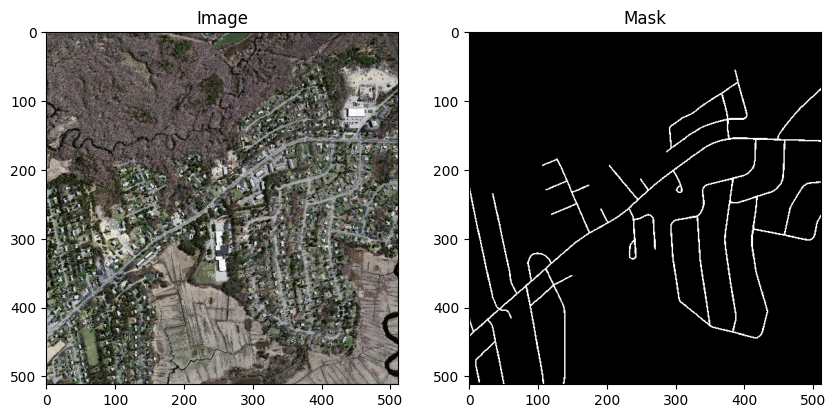

In [17]:
idx = 21
image, mask = trainset[idx]
def show_image(image, mask):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(np.transpose(image.numpy(), (1, 2, 0)))
    axes[0].set_title('Image')

    axes[1].imshow(np.transpose(mask.numpy(), (1, 2, 0)).squeeze(), cmap='gray')
    axes[1].set_title('Mask')

    plt.show()
show_image(image, mask)

# Task 5 : Load dataset into batches

In [18]:
from torch.utils.data import DataLoader

In [19]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [20]:
print(f'Total no. of batches in trainsloader : {len(trainloader)}')
print(f'Total no. of batches in validloader : {len(validloader)}')

Total no. of batches in trainsloader : 20
Total no. of batches in validloader : 5


In [21]:
for images, masks in trainloader:
  print(f"One batch image shape :  {images.shape}")
  print(f"One batch mask shape : {masks.shape}")
  break;

One batch image shape :  torch.Size([8, 3, 512, 512])
One batch mask shape : torch.Size([8, 1, 512, 512])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [22]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

from torch import nn

In [23]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.backbone = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks = None):

    logits = self.backbone(images)

    if masks != None:
      return logits, DiceLoss(mode = 'binary')(logits, masks) + nn.BCEWithLogitsLoss()(logits, masks)
    return logits

In [24]:
model = SegmentationModel()
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 152MB/s]


SegmentationModel(
  (backbone): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
      

# Task 7 : Create Train and Validation Function

In [25]:
def train_fn(dataloader, model, optimizer):

  model.train() #Trun ON droupout, batchnorm, etc..

  total_loss = 0.0

  for images, masks in tqdm(dataloader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [26]:
def eval_fn(dataloader, model):

  model.eval() #Trun OFF droupout, batchnorm, etc..

  total_loss = 0.0

  with torch.no_grad():

    for images, masks in tqdm(dataloader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)
      logits, loss = model(images, masks)
      total_loss += loss.item()

    return total_loss / len(dataloader)

# Task 8 : Train Model

In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [28]:
print(torch.cuda.is_available())

True


In [29]:
best_loss = np.Inf
for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_loss:
    torch.save(model.state_dict(), "best-model.pt")
    print("SAVED-MODEL")
    best_loss = valid_loss

  print(f"Epoch : {i+1} Train Loss : {train_loss} Valid Loss : {valid_loss}")

100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


SAVED-MODEL
Epoch : 1 Train Loss : 1.0565213412046432 Valid Loss : 1.01787371635437


100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


SAVED-MODEL
Epoch : 2 Train Loss : 0.7690028846263885 Valid Loss : 0.903861653804779


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


SAVED-MODEL
Epoch : 3 Train Loss : 0.7031803876161575 Valid Loss : 0.7615269660949707


100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


SAVED-MODEL
Epoch : 4 Train Loss : 0.6795784056186676 Valid Loss : 0.7150904536247253


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Epoch : 5 Train Loss : 0.651496022939682 Valid Loss : 0.7797880530357361


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Epoch : 6 Train Loss : 0.6440260231494903 Valid Loss : 0.7743350863456726


100%|██████████| 5/5 [00:06<00:00,  1.30s/it]


SAVED-MODEL
Epoch : 7 Train Loss : 0.6436535477638244 Valid Loss : 0.6866435050964356


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


Epoch : 8 Train Loss : 0.6404264718294144 Valid Loss : 0.6967380166053772


100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch : 9 Train Loss : 0.6254930049180984 Valid Loss : 0.705558717250824


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Epoch : 10 Train Loss : 0.6093441054224968 Valid Loss : 0.6881762623786927


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Epoch : 11 Train Loss : 0.6055113852024079 Valid Loss : 0.6999245882034302


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


SAVED-MODEL
Epoch : 12 Train Loss : 0.6014905840158462 Valid Loss : 0.6505011558532715


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


SAVED-MODEL
Epoch : 13 Train Loss : 0.6008876070380211 Valid Loss : 0.6338646411895752


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Epoch : 14 Train Loss : 0.5985639169812202 Valid Loss : 0.6996624708175659


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]

Epoch : 15 Train Loss : 0.5960427820682526 Valid Loss : 0.6498213529586792


# Task 9 : Inference

In [30]:
idx = 17
model.load_state_dict(torch.load('/content/best-model.pt'))
image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) #(c, h, w) -> (b, c, h, w)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

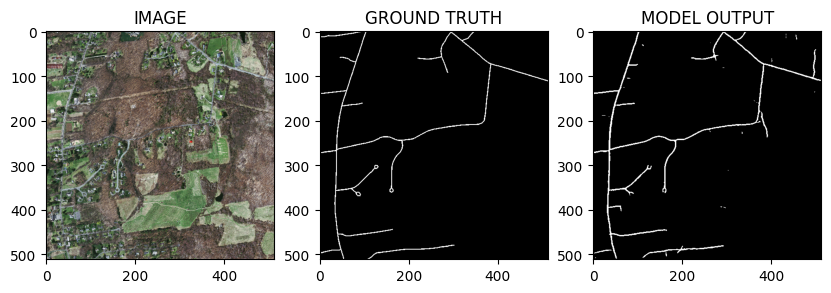

In [31]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya

